## Classification using Neural Networks (Keras)

- Dataset: Pima Indian Dataset link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
  - 다양한 데이터세트를 참조하려면 [Kaggle 사이트 참조]
- Library: Keras, Tensorflow

### Pima Indian Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. The target label of the dataset indicates if the person has been diagnosed with diabetes (1) or not (0)

- Pregnancies (number of times pregnant),
- Oral glucose tolerance test (plasma glucose concentration at 2 h),
- Blood Pressure (Diastolic Blood Pressure in mmHg),
- Skin Thickness (Triceps skin fold thickness in mm),
- Insulin (2 h serum insulin in mu U/ml),
- BMI (Body Mass Index in kg/m2),
- Age (years),
- Pedigree Diabetes Function ('function that represents how likely they are to get the disease by extrapolating from their ancestor’s history')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # 통계 data 를 위한 시각화 도구

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model # OLD: from keras.utils.vis_utils import plot_model
from keras.models import load_model

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [4]:
# load the dataset
df = pd.read_csv('C:\\temp\\diabetes.csv')

# print the columns name
print(df.columns)
print()

# rename the column DiabetesPedigreeFunction with DPF
df = df.rename({'DiabetesPedigreeFunction':'DMF'}, axis=1)
display(df.head())

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# determine which columns are identified, only attributes 
zero_fields = df.columns[1:-3].tolist()

# list number of 0-entries in each of the given columns
def check_zero_entries(data, column):
  print('Zero entries in each columns')
  for col in column:
    print('{:15}: {}' .format(col, len(data.loc[ data[col] == 0, col ])))

# check for each columns
check_zero_entries(df, zero_fields)

Zero entries in each columns
Glucose        : 5
BloodPressure  : 35
SkinThickness  : 227
Insulin        : 374
BMI            : 11


In [6]:
# create a copy data
df_full = df.copy()

# data imputation (결측치 보정) for zero value
def impute_zero_field(data, column):
    # get non zero values each column
    nonzero_vals = data.loc[data[column] != 0, column]
    
    # calculate the average
    avg = (np.sum(nonzero_vals) / len(nonzero_vals)).round(2)
    
    # total number of 0-entries
    k = len(data.loc[ data[column] == 0, column])   
    
    # replace 0 with the average
    data.loc[ data[column] == 0, column ] = avg

    print('{:15} ; fixed {:4} entries with {}'.format(column, k, avg))

# perform data imputation on attributes
for col in zero_fields:
    impute_zero_field(df_full, col)

# display the result
display(df_full.head())

Glucose         ; fixed    5 entries with 121.69
BloodPressure   ; fixed   35 entries with 72.41
SkinThickness   ; fixed  227 entries with 29.15
Insulin         ; fixed  374 entries with 155.55
BMI             ; fixed   11 entries with 32.46


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
0,6,148.0,72.0,35.00,155.55,33.6,0.627,50,1
1,1,85.0,66.0,29.00,155.55,26.6,0.351,31,0
2,8,183.0,64.0,29.15,155.55,23.3,0.672,32,1
3,1,89.0,66.0,23.00,94.00,28.1,0.167,21,0
4,0,137.0,40.0,35.00,168.00,43.1,2.288,33,1


Not all the columns are imputed, because for some values can make sense to be zero (like "Number of times pregnant").

### Simple Data Exploration

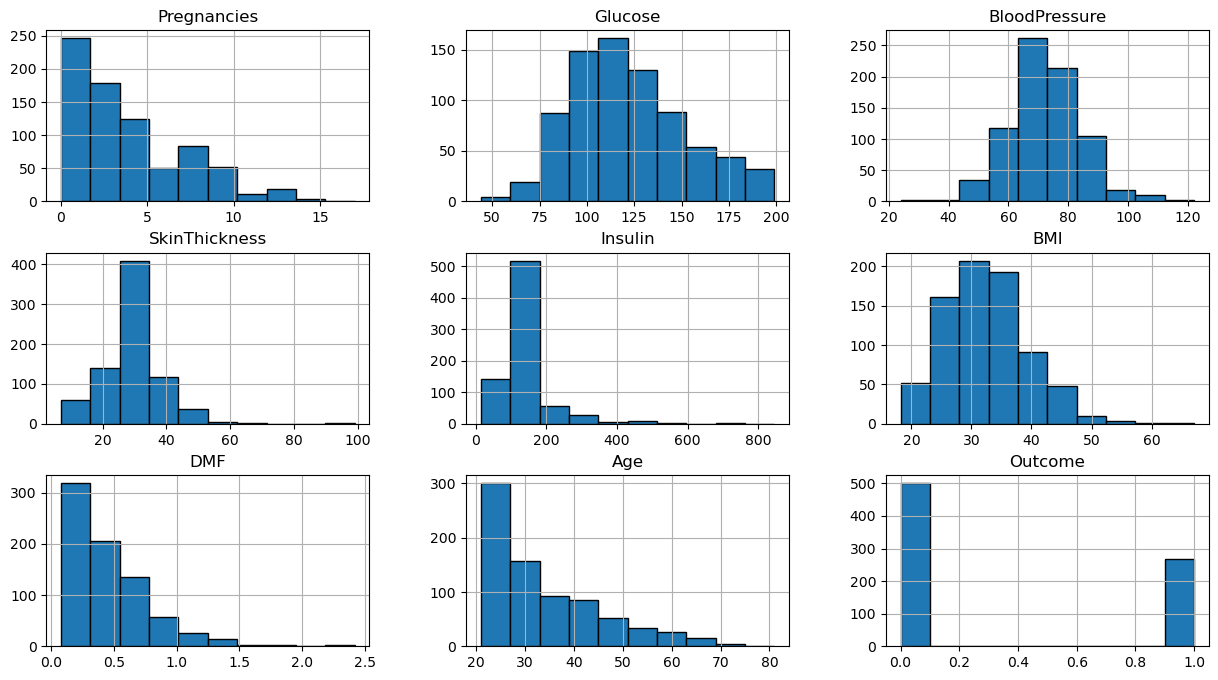

In [7]:
# plot the imputed data
df_full.hist(figsize=(15,8), edgecolor='black')
plt.show()

<Axes: xlabel='Outcome', ylabel='count'>

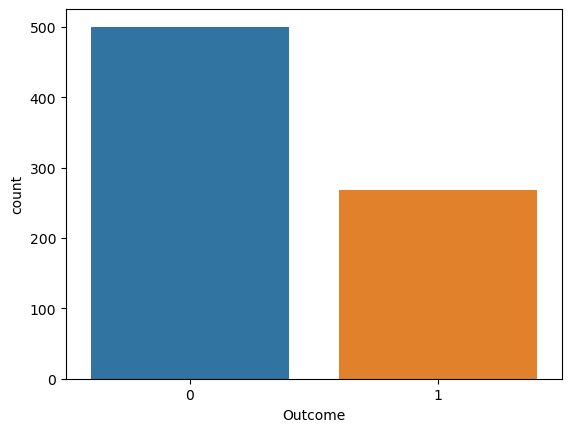

In [8]:
# distribution of outcome (label)
sns.countplot(x=df_full['Outcome'])

In [9]:
# data description
df_full.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DMF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686784,72.405404,29.152409,155.549089,32.457500,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.205000,29.150000,155.550000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.550000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Training and Testing Split

In [10]:
# Split into features and labes from imputed data
X = df_full.iloc[:,:-1].values
y = df_full.iloc[:,-1].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

# print the train and test set
print('Train Size {}'.format(X_train.shape))
print('Test Size {}'.format(X_test.shape))

Train Size (537, 8)
Test Size (231, 8)


### Neural Networks

In [11]:
# fix random seed for reproducibility
np.random.seed(10)

# Build the Networks with 3 hidden layers
def neural_network(n_inputs=8):
    model = Sequential()
    
    # input layer = 8 nodes, hidden Layer = 16 nodes
    model.add(Dense(16, input_dim=n_inputs, activation='relu'))
    
    # hidden layer = 8 nodes
    model.add(Dense(8, activation='relu'))

    # hidden layer = 8 nodes
    model.add(Dense(8, activation='relu'))
    
    # output layer = 1 node --> binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model, you can use other loss function/optimizer
    model.compile(loss='binary_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy'])
    return model

# generate the model
nn_model = neural_network()

# summarized the mode
nn_model.summary()

# init the parameters
n_epochs = 200
n_batch_size = 16
val_split = 0.2

# option 1: train the network and validate with 0.1 of training data
# history = nn_model.fit(X_train, y_train, validation_split=val_split, epochs=100, batch_size=10, verbose=False)

# option 2: train the network and validate with test data
print('\nstart training ....')
history = nn_model.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=n_epochs, 
                       batch_size=n_batch_size, 
                       verbose=False)
%time
print('finish .....')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

start training ....


CPU times: total: 0 ns
Wall time: 0 ns
finish .....


- Keras model summary

This model only use 3 hidden layers
'#' params (dense_1) = 144. This is obtained as : 8 (input values) * 16 (neurons in the first layer) + 16 (bias values). Same calculation for the rest of layers.


### Model Evaluation

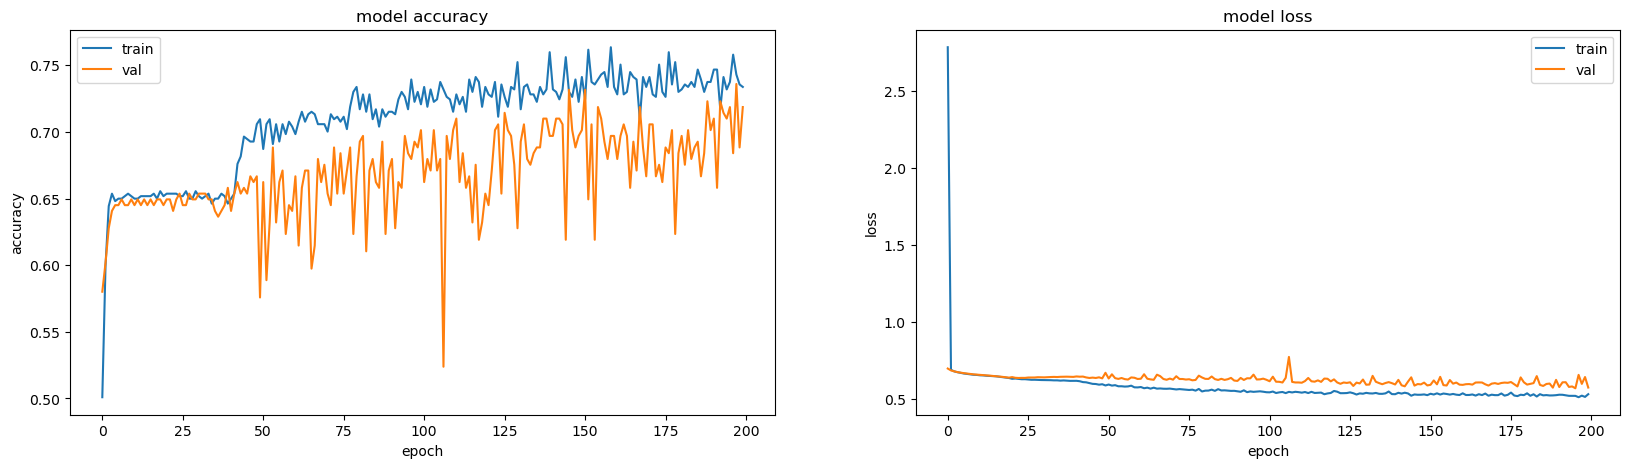

In [12]:
# summarize for accuracy score
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

# summarize for loss score
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [13]:
# Evaluate the model (training accuracy)
train_scores = nn_model.evaluate(X_train, y_train, verbose=False)
print('(Training) %s: %.2f%%' % (nn_model.metrics_names[1], train_scores[1]*100))

# Evaluate the model (testing accuracy)
test_scores = nn_model.evaluate(X_test, y_test, verbose=False)
print('(Testing) %s: %.2f%%' % (nn_model.metrics_names[1], test_scores[1]*100))

(Training) accuracy: 74.86%
(Testing) accuracy: 71.86%


In [14]:
# make probability prediction with the model
prediction = nn_model.predict(X_test)

# round prediction
rounded = [round(x[0]) for x in prediction]

# make class predictions with the model
cls_prediction = (nn_model.predict(X_test) > 0.5).astype("int32")

8/8 [==============================] - 0s 997us/step


Confusion Matrix


,Predicted No,Predicted Yes
Actual No,139,11
Actual Yes,54,27


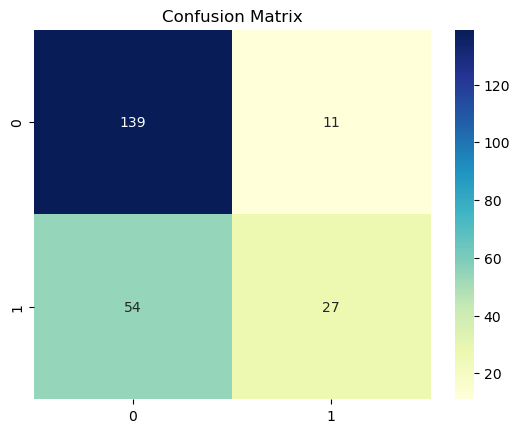


Classification Report
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       150
           1       0.71      0.33      0.45        81

    accuracy                           0.72       231
   macro avg       0.72      0.63      0.63       231
weighted avg       0.72      0.72      0.69       231



In [15]:
# evaluate the performance
print('Confusion Matrix')
display(pd.DataFrame(confusion_matrix(y_test, cls_prediction),
             columns=['Predicted No', 'Predicted Yes'],
             index=['Actual No', 'Actual Yes']
             ))

# plot the confusion matrix
print()
sns.heatmap(confusion_matrix(y_test, cls_prediction), annot=True, fmt='.3g', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()

# classification report
print('\nClassification Report')
print(classification_report(y_test, cls_prediction))

### Experiment Results

- The objective of this work is to apply neural network model for diabetes classification.
- This model use 3 hidden layers with SGD optimizer
- The more hidden layer on the networks can increase the performance.
- In order to enhance the performance, you can apply hyperparameter tuning (e.g., add momentum, weight decay, or dropout layer).